In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
from matplotlib.transforms import Bbox
import scienceplots             # needed for 'science' style

# ensure inline rendering matches saved figure / uncomment for larger inline figures
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

DATA_DIR = Path("results")
FIG_DIR  = Path("figures")

# layout defaults and common labels
SINGLE_COL_WIDTH = 3.5
DOUBLE_COL_WIDTH = 7.16
DPI = 150
FIELD_SYMBOL = "g"
SUPPORT_LABEL_T = r"Support $g$"

# z-ordering
Z_BG   = 0
Z_REF  = 2
Z_DATA = 3

# global plot styling using scienceplots
plt.style.use(["science", "ieee"])
plt.rcParams.update({"mathtext.fontset": "cm", "text.usetex": False})

# hardcoded seaborn-colorblind palette
SB_COLORBLIND = [
    "#0173b2", "#de8f05", "#029e73", "#d55e00", "#cc78bc",
    "#ca9161", "#fbafe4", "#949494", "#ece133", "#56b4e9",
]

STYLE_REF = {
    "linestyle": "--", "color": "black", "alpha": 0.7,
    "linewidth": 1.0, "label": "ED Reference",
}

STYLE_MAIN = {
    "linestyle": "-", "linewidth": 1.0, "alpha": 0.9, "marker": "o",
    "markeredgewidth": 0.0, "color": SB_COLORBLIND[0],
}

print("Global styles defined.")

Global styles defined.


In [2]:
DATA_FILENAME = "tfim_16_entangle_rbm_20251212_030007.csv"
REF_FILENAME  = "tfim_16_entangle_ref.csv"

df_res = pd.read_csv(DATA_DIR / DATA_FILENAME)

ref_path = DATA_DIR / REF_FILENAME
ref_df = pd.read_csv(ref_path) if ref_path.exists() else pd.DataFrame()

# ensure numeric types for magnetic field
df_res["h"] = df_res["h"].astype(float)
if not ref_df.empty:
    ref_df["h"] = ref_df["h"].astype(float)
    ref_df["l"] = ref_df["l"].astype(int)
    ref_df["s2"] = ref_df["s2"].astype(float)

# preprocess for 3d surface by pivoting (rows: l, cols: h, values: s2)
pivot_df = df_res.pivot(index="l", columns="h", values="s2")
pivot_df = pivot_df.sort_index(axis=0).sort_index(axis=1)  # monotonic mesh

h_dense = pivot_df.columns.values.astype(float)
l_values = pivot_df.index.values.astype(int)
Z_s2 = pivot_df.values

# identify support cuts from data
support_h_keys = np.sort(df_res[df_res["type"] == "support"]["h"].unique())

# precompute color map and cut data
h_sorted = sorted(float(h) for h in support_h_keys)
h_to_color = {h0: SB_COLORBLIND[i % len(SB_COLORBLIND)] for i, h0 in enumerate(h_sorted)}

cut_data = {}
for h0 in h_sorted:
    subset = df_res[df_res["h"] == h0].sort_values("l")
    cut_data[h0] = {"ell": subset["l"].values.astype(int), "s2":  subset["s2"].values.astype(float)}

# precompute ED reference curves
def _extract_ref_curve(ref_df_local: pd.DataFrame, h0: float):
    if ref_df_local.empty:
        return None

    subset = ref_df_local[np.isclose(ref_df_local["h"], h0, atol=1e-6)]
    if subset.empty:
        return None

    subset = subset.sort_values("l")
    return (subset["l"].values.astype(int), subset["s2"].values.astype(float))

ref_curves = ({h0: _extract_ref_curve(ref_df, h0) for h0 in h_sorted} if not ref_df.empty else {})

print("Data Loaded.")
print(f"Dimensions: h={len(h_dense)}, l={len(l_values)}")
print(f"Support cuts found at {FIELD_SYMBOL}={support_h_keys}")

Data Loaded.
Dimensions: h=21, l=8
Support cuts found at g=[0.5  0.8  0.95 1.   1.05 1.2  1.5 ]


Saved: tfim_16_entangle_2d.pdf


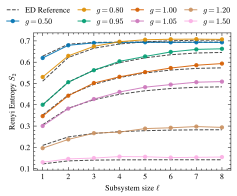

In [3]:
FIG_NAME = "tfim_16_entangle_2d.pdf"

# local styling
FIG_HEIGHT_RATIO = 0.85
width  = SINGLE_COL_WIDTH
height = width * FIG_HEIGHT_RATIO
MARKER_SIZE  = 4.3
MARKER_EDGEW = 0.0

# legend config
LEGEND_ANCHOR = (0.43, 1.03)
LEGEND_LOC    = "lower center"
LEGEND_NCOL   = 4

fig, ax = plt.subplots(figsize=(width, height), dpi=DPI)

ref_label_added = False

for h0 in h_sorted:
    ell = cut_data[h0]["ell"]
    s2  = cut_data[h0]["s2"]
    color = h_to_color[h0]

    # reference curve
    curve = ref_curves.get(h0)
    if curve is not None:
        x_ref, y_ref = curve

        style_local = STYLE_REF.copy()
        style_local["label"] = style_local["label"] if not ref_label_added else "_nolegend_"

        ax.plot(x_ref, y_ref, **style_local, zorder=Z_REF)
        ref_label_added = True

    # model curve
    ax.plot(
        ell, s2,
        label=rf"${FIELD_SYMBOL}={h0:.2f}$",
        color=color,
        linestyle=STYLE_MAIN["linestyle"],
        linewidth=STYLE_MAIN["linewidth"],
        alpha=STYLE_MAIN["alpha"],
        marker=STYLE_MAIN["marker"],
        markersize=MARKER_SIZE,
        fillstyle="full",
        markerfacecolor=color,
        markeredgecolor=color,
        markeredgewidth=MARKER_EDGEW,
        zorder=Z_DATA,
    )

ax.set_xlabel(r"Subsystem size $\ell$")
ax.set_ylabel(r"Renyi Entropy $S_2$")
ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
ax.grid(False)

leg = ax.legend(
    frameon=False, ncol=LEGEND_NCOL, loc=LEGEND_LOC,
    bbox_to_anchor=LEGEND_ANCHOR, columnspacing=1.0,
    handlelength=1.5, borderaxespad=0.0,
)

fig.tight_layout()

if FIG_NAME:
    fig.savefig(FIG_DIR / FIG_NAME, bbox_inches="tight", bbox_extra_artists=[leg])
    print(f"Saved: {FIG_NAME}")

plt.show()

In [4]:
# common 3D helper functions to be used in surface plots


# properly set up 3D axes (padding handled later)
def setup_entropy_axes(fig, pos_shift, box_aspect):
    ax = fig.add_subplot(111, projection="3d")
    ax.set_proj_type("ortho")

    pos = ax.get_position()
    ax.set_position([pos.x0 + pos_shift, pos.y0, pos.width, pos.height])

    ax.zaxis._axinfo["juggled"] = (1, 0, 2)

    ax.minorticks_off()
    grid_style = {"color": "gray", "linewidth": 0.5, "alpha": 0.3}

    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.set_minor_locator(mticker.NullLocator())
        axis._axinfo["grid"].update(grid_style)
        axis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.2))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(mticker.MultipleLocator(0.2))

    ax.set_box_aspect(box_aspect)
    return ax


# we add some small tails to the surface such that the first and last support cuts have some backdrop
def get_extended_surface(h_dense, l_values, Z_s2, tail_pad):
    h_min, h_max = float(h_dense.min()), float(h_dense.max())
    h_ext = np.concatenate([[h_min - tail_pad], h_dense, [h_max + tail_pad]])
    Z_ext = np.concatenate([Z_s2[:, [0]], Z_s2, Z_s2[:, [-1]]], axis=1)
    X_ext, Y_ext = np.meshgrid(h_ext, l_values)
    return X_ext, Y_ext, Z_ext, h_min, h_max


# we have to draw small ribbons around each cut to avoid z-fighting with the surface
def get_ribbon_surface(ell_arr, h_val, s2_arr, ribbon_pad):
    h_l, h_r = h_val - ribbon_pad, h_val + ribbon_pad
    X_rib = np.vstack([np.full_like(ell_arr, h_l, dtype=float), np.full_like(ell_arr, h_r, dtype=float)])
    Y_rib = np.vstack([ell_arr, ell_arr])
    Z_rib = np.vstack([s2_arr, s2_arr])
    return X_rib, Y_rib, Z_rib


# final labeling and tick styling (will be called after fig.canvas.draw())
def finalize_and_style_ticks(ax, tick_pads, label_pads, text_size, tick_size, field_symbol="g"):
    ax.set_xlabel(rf"Transverse Field ${field_symbol}$", fontsize=text_size, labelpad=label_pads[0])
    ax.set_ylabel(r"Subsystem Size $\ell$", fontsize=text_size, labelpad=label_pads[1])
    ax.set_zlabel("", labelpad=label_pads[2])

    # padding between ticks and axes
    for t in ax.xaxis.get_major_ticks(): t.set_pad(tick_pads[0])
    for t in ax.yaxis.get_major_ticks(): t.set_pad(tick_pads[1])
    for t in ax.zaxis.get_major_ticks(): t.set_pad(tick_pads[2])

    # tick font sizes and clipping
    for lab in ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels():
        lab.set_clip_on(False)
        lab.set_fontsize(tick_size)

    # tighten axis-label spacing
    ax.xaxis._axinfo["label"]["space_factor"] = 0.0
    ax.yaxis._axinfo["label"]["space_factor"] = 0.0
    ax.zaxis._axinfo["label"]["space_factor"] = 0.0

# calculate a cropping bbox for saving figures
def get_crop_bbox(fig, crop_params):
    fw, fh = fig.get_size_inches()
    l, r, b, t, sx, sy, scx, scy = crop_params

    x0, y0 = l, b
    w0, h0 = 1.0 - l - r, 1.0 - b - t
    cx, cy = x0 + 0.5*w0 + sx, y0 + 0.5*h0 + sy
    w, h   = w0 * scx, h0 * scy

    x0n, y0n = max(0.0, min(1.0, cx - 0.5*w)), max(0.0, min(1.0, cy - 0.5*h))
    x1n, y1n = max(0.0, min(1.0, cx + 0.5*w)), max(0.0, min(1.0, cy + 0.5*h))

    if x1n <= x0n: x1n = min(1.0, x0n + 1e-3)
    if y1n <= y0n: y1n = min(1.0, y0n + 1e-3)

    return Bbox.from_extents(x0n*fw, y0n*fh, x1n*fw, y1n*fh)

print("3D Helpers defined.")

3D Helpers defined.


Saved: tfim_16_entangle_3d.pdf


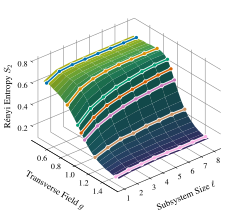

In [5]:
FIG_NAME = "tfim_16_entangle_3d.pdf"

# custom knobs for this 3D figure
TEXT_SIZE, TICK_SIZE, LEGEND_SIZE = 9, 8, 8
BOX_ASPECT = (1.0, 1.0, 0.7)
VIEW = (30, -40)  # elevation, azimuth
SHIFT_X = -0.02

RIBBON_PAD = 0.02
TAIL_PAD   = 0.045
TICK_PADS  = (-3, -3, -3)  # ticks to axis
LABEL_PADS = (0, 0, 0)     # label to axis (tight)

# styling for cut overlays (white underlay and colored line)
CUT_STYLES = {
    "white": {"linewidth": 3.2, "markersize": 5.0, "color": "white", "markeredgewidth": 0.0},
    "color": {"linewidth": 1.5, "markersize": 3.3, "markeredgewidth": 0.0},
}

width  = SINGLE_COL_WIDTH
height = width * 1.15

# we need to override some rcParams for proper white background in 3D
with plt.rc_context({"figure.facecolor": "white", "axes.facecolor": "white", "axes.labelsize": TEXT_SIZE,
                     "legend.fontsize": LEGEND_SIZE}):

    fig = plt.figure(figsize=(width, height), dpi=DPI)
    fig.subplots_adjust(left=0.16, right=0.98, top=0.98, bottom=0.08)

    ax3d = setup_entropy_axes(fig, SHIFT_X, BOX_ASPECT)

    X_ext, Y_ext, Z_ext, _, _ = get_extended_surface(h_dense, l_values, Z_s2, TAIL_PAD)

    norm_h = mcolors.Normalize(vmin=X_ext.min(), vmax=X_ext.max())
    t = 0.10 + 0.85 * (1.0 - norm_h(X_ext))
    surface_colors = plt.get_cmap("viridis")(t)

    ax3d.plot_surface(X_ext, Y_ext, Z_ext, facecolors=surface_colors, rstride=1, cstride=1,
                      shade=True, linewidth=0, alpha=1.0, antialiased=True)

    # cut overlays
    for h0 in h_sorted:
        ell = cut_data[h0]["ell"].astype(int)
        s2  = cut_data[h0]["s2"].astype(float)
        color = h_to_color[h0]

        Xr, Yr, Zr = get_ribbon_surface(ell, h0, s2, RIBBON_PAD)
        ax3d.plot_surface(Xr, Yr, Zr, color=color, shade=True, linewidth=0, alpha=1.0, antialiased=True)

        # cuts (explicit float dtype prevents silent truncation of h-values to integers)
        xline = np.full_like(ell, h0, dtype=float)
        common = {"linestyle": "-", "marker": "o", "markevery": 1,
            "solid_capstyle": "round", "solid_joinstyle": "round"}

        ax3d.plot(xline, ell, s2, alpha=0.95, zorder=19, **CUT_STYLES["white"], **common)
        ax3d.plot(xline, ell, s2, color=color, alpha=1.0, zorder=20,
                  markeredgecolor=color, **CUT_STYLES["color"], **common)

    ax3d.set_zlim(np.min(Z_s2) - 0.05, np.max(Z_s2) + 0.1)
    ax3d.view_init(*VIEW)

    zlab = ax3d.text2D(-0.04, 0.55, r"Rényi Entropy $S_2$", transform=ax3d.transAxes,
                       rotation=90, va="center", ha="right", fontsize=TEXT_SIZE, clip_on=False)

    fig.canvas.draw()
    finalize_and_style_ticks(ax3d, TICK_PADS, LABEL_PADS, TEXT_SIZE, TICK_SIZE, FIELD_SYMBOL)

    if FIG_NAME:
        crop_pars = (0.05, 0.04, 0.15, 0.14, 0.0, 0.0, 1.0, 1.0)
        fig.savefig(FIG_DIR / FIG_NAME, bbox_inches=get_crop_bbox(fig, crop_pars), bbox_extra_artists=[zlab])
        print(f"Saved: {FIG_NAME}")

    plt.show()

Saved: tfim_16_entangle_hero.svg


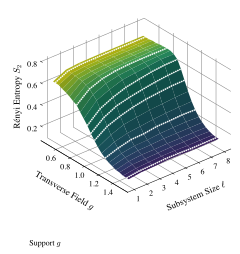

In [6]:
FIG_NAME = "tfim_16_entangle_hero.svg"

# custom knobs for this 3D figure
TEXT_SIZE, TICK_SIZE, LEGEND_SIZE = 9, 8, 8
BOX_ASPECT = (1.0, 1.0, 0.7)
VIEW = (30, -40)
SHIFT_X = -0.02
TAIL_PAD = 0.03
Z_LIFT = 1e-4
TICK_PADS = (-3, -3, -3)
LABEL_PADS = (0, 0, 0)

width  = SINGLE_COL_WIDTH
height = width * 1.15

DOT_STYLE = {"linestyle": "-", "dashes": (1.0, 0.5), "linewidth": 1.5, "color": "white", "alpha": 0.95}

with plt.rc_context({"figure.facecolor": "white", "axes.facecolor": "white", "savefig.facecolor": "white",
                     "savefig.transparent": False, "axes.labelsize": TEXT_SIZE, "legend.fontsize": LEGEND_SIZE}):
    fig = plt.figure(figsize=(width, height), dpi=DPI)
    fig.patch.set_alpha(1.0)
    fig.subplots_adjust(left=0.16, right=0.98, top=0.98, bottom=0.08)

    ax3d = setup_entropy_axes(fig, SHIFT_X, BOX_ASPECT)

    X_ext, Y_ext, Z_ext, h_min, h_max = get_extended_surface(h_dense, l_values, Z_s2, TAIL_PAD)

    X_color = np.clip(X_ext, h_min, h_max)
    norm_h = mcolors.Normalize(vmin=h_min, vmax=h_max)
    t = 0.10 + 0.85 * (1.0 - norm_h(X_color))

    ax3d.plot_surface(X_ext, Y_ext, Z_ext, facecolors=plt.get_cmap("viridis")(t), rstride=1, cstride=1,
                      shade=True, linewidth=0, alpha=1.0, antialiased=True)

    for h0 in h_sorted:
        ell = cut_data[h0]["ell"].astype(int)
        s2  = cut_data[h0]["s2"].astype(float) + Z_LIFT
        xline = np.full_like(ell, h0, dtype=float)

        ax3d.plot(xline, ell, s2, **DOT_STYLE, zorder=20, solid_capstyle="round", solid_joinstyle="round")

    ax3d.set_zlim(np.min(Z_s2) - 0.05, np.max(Z_s2) + 0.1)
    ax3d.view_init(*VIEW)

    zlab = ax3d.text2D(-0.04, 0.55, r"Rényi Entropy $S_2$", transform=ax3d.transAxes,
                       rotation=90, va="center", ha="right", fontsize=TEXT_SIZE, clip_on=False)

    fig.legend(handles=[Line2D([0], [0], **DOT_STYLE)], labels=[SUPPORT_LABEL_T],
               loc="lower left", bbox_to_anchor=(0.02, 0.02), frameon=False)

    fig.canvas.draw()
    finalize_and_style_ticks(ax3d, TICK_PADS, LABEL_PADS, TEXT_SIZE, TICK_SIZE, FIELD_SYMBOL)

    if FIG_NAME:
        crop_pars = (-0.05, 0.04, -0.2, 0.14, 0.0, 0.0, 1.0, 1.0)
        fig.savefig(FIG_DIR / FIG_NAME, bbox_inches=get_crop_bbox(fig, crop_pars), bbox_extra_artists=[zlab])
        print(f"Saved: {FIG_NAME}")

    plt.show()

In [7]:
FIG_NAME = "tfim_16_viridis_bar.svg"

# bar geometry
BAR_WIDTH  = 2.0
BAR_HEIGHT = 0.3
DPI_BAR    = 200

# continuous gradient
W = 1000
grad = [[1 - i / (W - 1) for i in range(W)]]

fig, ax = plt.subplots(figsize=(BAR_WIDTH, BAR_HEIGHT), dpi=DPI_BAR)
ax.imshow(grad, cmap="viridis", aspect="auto", interpolation="bilinear")
ax.set_axis_off()

if FIG_NAME:
    fig.savefig(FIG_DIR / FIG_NAME, bbox_inches="tight", pad_inches=0, transparent=True)
    print(f"Saved: {FIG_NAME}")

plt.show()

Saved: tfim_16_viridis_bar.svg
